In [8]:
import numpy as np
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt


In [ ]:
def nuclear_norm(X):
    _, sigma, _ = np.linalg.svd(X)
    return np.sum(sigma)

In [13]:
def matrix_completion_admm(B, Omega, mu, lambda_, max_iter, tol):
    """
    ADMM for low-rank nonnegative matrix completion

    Parameters:
        B (ndarray): Observed matrix (with missing entries as 0).
        Omega (ndarray): Logical mask for observed entries (True if observed, False otherwise).
        mu (float): Regularization parameter for nuclear norm.
        lambda_ (float): Penalty parameter for augmented Lagrangian.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.

    Returns:
        ndarray: Completed matrix.
    """
    # Problem dimensions
    m, n = B.shape

    # Initialize variables
    X = np.zeros((m, n))  # Optimization variable
    Y = np.zeros((m, n))  # Dual variable
    Z = np.zeros((m, n))  # Lagrange multiplier

    # Projection operators
    def P_Omega(X):
        return Omega * X

    def P_Omega_c(X):
        return (1 - Omega) * X

    def P_plus(X):
        return np.maximum(X, 0)  # Projection onto nonnegative matrices

    # Objective function
    def nuclear_norm(M):
        return np.sum(np.linalg.svd(M, compute_uv=False))

    def objective(X, Y):
        return mu * nuclear_norm(Y) + 0.5 * np.linalg.norm(P_Omega(X) - P_Omega(B))**2

    # Track objective function values
    objective_values = []
    ranks = []

    # ADMM iterations
    for k in range(max_iter):
        # Step 1: Update X
        X = P_plus((1 / (1 + lambda_)) * P_Omega(B + lambda_ * Y - Z) + \
                   P_Omega_c(Y - (1 / lambda_) * Z))

        # Step 2: Update Y (using SVD and soft-thresholding)
        U, S, Vt = np.linalg.svd(X + (1 / lambda_) * Z, full_matrices=False)
        S_thresh = np.maximum(S - mu / lambda_, 0)
        Y = (U * S_thresh) @ Vt

        # Step 3: Update Z
        Z = Z + lambda_ * (X - Y)

        # Record objective value
        obj_val = objective(X, Y)
        objective_values.append(obj_val)
        ranks.append(np.linalg.matrix_rank(X))

        # Check convergence
        if k > 0 and abs(objective_values[-1] - objective_values[-2]) / objective_values[-2] < tol:
            print(f"Converged in {k+1} iterations.")
            break
    else:
        print("Reached maximum iterations without full convergence.")

    # Plot objective values
    plt.figure()
    plt.plot(objective_values, label='Objective value')
    plt.plot(ranks, label='rank')
    plt.xlabel('Iteration')
    
    plt.title('ADMM Objective Convergence')
    plt.legend()
    plt.grid()
    plt.show()

    return X


Converged in 71 iterations.


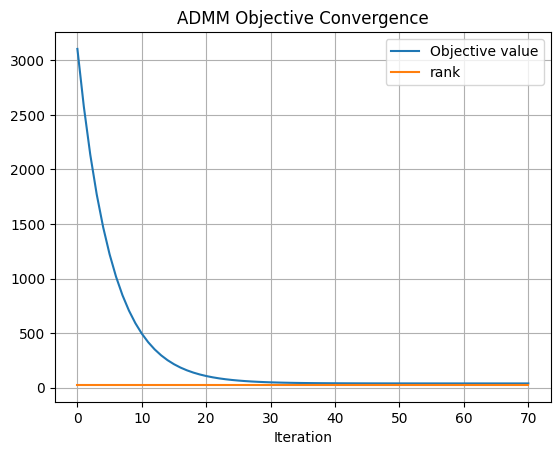

Completed matrix:
[[7.68374716e-02 8.95254851e-03 4.98116811e+00 ... 6.55732082e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.87296612e-02 8.94173727e+00 ... 0.00000000e+00
  3.12905242e-03 3.33353681e-02]
 [2.98366032e+00 1.94839490e-03 1.08204445e-02 ... 4.83570574e-02
  0.00000000e+00 2.60788472e-02]
 ...
 [9.82606016e-02 0.00000000e+00 6.03403508e-02 ... 2.34088276e-02
  8.38265659e-03 8.40168947e-03]
 [5.96134452e+00 0.00000000e+00 3.04257080e-02 ... 0.00000000e+00
  2.98170735e+00 1.01556855e-02]
 [1.68438764e-02 9.92539962e-01 0.00000000e+00 ... 1.47060254e-02
  0.00000000e+00 1.16330755e-01]]


In [17]:
m = 50
n = 25
sparsity = 0.2

B = np.random.randint(0, 10, (m, n))*(np.random.rand(m, n) < sparsity)

Omega = B > 0  # Logical mask for observed entries
mu = 0.1       # Regularization parameter
lambda_ = 10   # Penalty parameter
max_iter = 1000 # Maximum iterations
tol = 1e-4     # Convergence tolerance

# Solve the matrix completion problem
X = matrix_completion_admm(B, Omega, mu, lambda_, max_iter, tol)
print("Completed matrix:")
print(X)
